# Doing a Transformation in a Changed Basis

**The Big Question:** Imagine you have a robot that can rotate objects, but it thinks in terms of different coordinate axes than you do. How do you tell the robot to perform the same rotation, but using *its* coordinate system?

This is the essence of **similarity transformations** - adapting known transformations to work in different coordinate systems.

**Real-World Example:** A graphics card might store 3D models in "object space" (relative to the object's center), but need to apply lighting calculations in "world space" (relative to the scene). The same rotation matrix looks different in each coordinate system!

**Goal:** Learn how to apply a known linear transformation (e.g., a rotation) to vectors **given in another basis**.

If a transformation has matrix **R** in the **standard basis**, then its matrix in a new basis with matrix **B** is the **similarity transform**:
$$R_{\text{new basis}} = B^{-1} R B$$

We'll:
- Build intuition for why this formula works
- Work through concrete examples with visualizations  
- Verify the math with step-by-step calculations
- Generalize to any linear transformation (rotations, scaling, shearing)

---

## Learning Objectives
By the end, you'll be able to:
- **Explain** why similarity transforms arise when changing coordinate systems
- **Compute** $B^{-1}RB$ for any transformation $R$ and basis $B$
- **Verify** that transformations work consistently across coordinate systems
- **Apply** this concept to rotations, scaling, and shearing transformations

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Better printing for cleaner output
np.set_printoptions(precision=4, suppress=True)

# For reproducible random examples
np.random.seed(42)

print("Libraries imported! Ready to explore similarity transformations.")

Libraries imported! Ready to explore similarity transformations.


## The Core Idea: Similarity Transformations

**Think of it like translation between languages:**

1. **You speak English**, Robot speaks French
2. You want to say "rotate 45 degrees clockwise"  
3. **Translation process:**
   - Convert your English instruction to "universal language" (math)
   - Apply the mathematical operation  
   - Translate the result back to French for the robot

**In linear algebra:**
1. **Standard basis** = your coordinate system, **Bear's basis** = robot's system
2. You know transformation matrix **R** in standard coordinates
3. **Similarity transform process:**
   - Convert Bear's coordinates to standard: multiply by **B**
   - Apply your transformation: multiply by **R**  
   - Convert back to Bear's coordinates: multiply by **B⁻¹**
   - Combined: **B⁻¹RB** = transformation matrix in Bear's language

**Key insight:** Same geometric transformation, different coordinate representation!


## Helper functions

- `basis_matrix(*cols)`: stack basis vectors as columns to form **B**.  
- `to_world(B, v_basis)`: coordinates in basis → world via $B\,v_{\text{basis}}$.  
- `to_basis(B, v_world)`: world → basis via $B^{-1} v$.  
- `similarity_transform(B, R)`: compute $B^{-1} R B$.  
- `apply_in_basis(B, R, v_basis)`: apply $R$ (given in world basis) to a vector given in the **B** basis.


In [12]:
def basis_matrix(*cols):
    """Create a basis matrix from column vectors.
    
    Args:
        *cols: Basis vectors as columns
        
    Returns:
        np.ndarray: Matrix where each column is a basis vector
    """
    return np.column_stack([np.asarray(col, dtype=float) for col in cols])

def to_world(B, v_basis):
    """Convert vector from custom basis to world coordinates.
    
    Think: "I know my position relative to Bear's landmarks, 
           what's my position on the standard map?"
    
    Args:
        B: Basis matrix (columns are basis vectors in world coords)
        v_basis: Vector coordinates in the custom basis
        
    Returns:
        Vector in world coordinates
        
    Math: v_world = B @ v_basis
    """
    return B @ np.asarray(v_basis)

def to_basis(B, v_world):
    """Convert vector from world to custom basis coordinates.
    
    Think: "I know my standard map position,
           how would Bear describe my location?"
    
    Args:
        B: Basis matrix  
        v_world: Vector in world coordinates
        
    Returns:
        Vector coordinates in the custom basis
        
    Math: v_basis = B⁻¹ @ v_world
    """
    try:
        return np.linalg.solve(B, np.asarray(v_world))
    except np.linalg.LinAlgError:
        raise ValueError("Basis matrix is singular (not invertible)")

def similarity_transform(B, R):
    """Compute similarity transform: B⁻¹RB
    
    This gives you the matrix representation of transformation R
    when working in the coordinate system defined by basis B.
    
    Args:
        B: Basis matrix (columns are new basis vectors)
        R: Transformation matrix in standard coordinates
        
    Returns:
        Transformation matrix in the new basis coordinates
        
    Math: R_new = B⁻¹ @ R @ B
    """
    try:
        B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
        return B_inv @ R @ B
    except np.linalg.LinAlgError:
        raise ValueError("Basis matrix is singular (not invertible)")

def apply_transform_in_basis(B, R, v_basis):
    """Apply a transformation (given in world coords) to a vector in custom basis.
    
    This is the "long way" that helps verify our similarity transform works.
    
    Args:
        B: Basis matrix
        R: Transformation in world coordinates  
        v_basis: Vector in custom basis coordinates
        
    Returns:
        Transformed vector, still in custom basis coordinates
        
    Process: basis → world → transform → back to basis
    """
    v_world = to_world(B, v_basis)        # Convert to world
    v_world_transformed = R @ v_world     # Apply transformation  
    return to_basis(B, v_world_transformed)  # Convert back to basis

print("Helper functions defined! 🛠️")

Helper functions defined! 🛠️


## Example: 45° Rotation in Bear's Coordinate System

**Setup:** Bear uses a tilted, non-orthogonal coordinate system for navigation. We want to rotate vectors in Bear's world, but we only know how to rotate in standard coordinates.

**Bear's Basis Vectors** (expressed in our standard coordinates):
- `b₁ = [3, 1]` - Bear's "first direction" (points mostly right, slightly up)
- `b₂ = [1, 1]` - Bear's "second direction" (points northeast at 45°)

The basis matrix is:
$$
B = \begin{bmatrix}3 & 1\\ 1 & 1\end{bmatrix}
$$

**Standard 45° Rotation Matrix:**
$$
R = \begin{bmatrix}\cos 45^\circ & -\sin 45^\circ \\ \sin 45^\circ & \cos 45^\circ\end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & -1\\ 1 & 1\end{bmatrix}
$$

**The Question:** What matrix should we use to rotate vectors that are *already expressed in Bear's coordinates*?

**Answer:** The similarity transform $R_{\text{Bear}} = B^{-1} R B$

**Why this works:** 
1. $B$ converts Bear coordinates → standard coordinates
2. $R$ applies rotation in standard coordinates  
3. $B^{-1}$ converts back to Bear coordinates
4. Combined: one matrix that rotates directly in Bear's system!

In [13]:
# Define Bear's non-orthogonal basis
bear_b1 = [3., 1.]  # Bear's first basis vector
bear_b2 = [1., 1.]  # Bear's second basis vector
B_bear = basis_matrix(bear_b1, bear_b2)

# Define 45-degree rotation in standard coordinates
angle_45 = np.pi / 4
R_standard = np.array([[np.cos(angle_45), -np.sin(angle_45)],
                       [np.sin(angle_45),  np.cos(angle_45)]])

# Alternative form (equivalent)
R_standard_alt = (1/np.sqrt(2)) * np.array([[1., -1.],
                                            [1.,  1.]])

print("Bear's basis matrix B:")
print(B_bear)
print(f"\nBear's basis vectors:")
print(f"b₁ = {bear_b1} (points mostly right)")
print(f"b₂ = {bear_b2} (points northeast)")

print(f"\n45° rotation matrix in standard coordinates:")
print(R_standard)
print(f"Verification: cos(45°) = sin(45°) = {1/np.sqrt(2):.4f}")

# Compute the similarity transform
B_bear_inv = np.linalg.inv(B_bear)
R_bear = similarity_transform(B_bear, R_standard)

print(f"\nB⁻¹ (inverse of Bear's basis):")
print(B_bear_inv)

print(f"\nR_Bear = B⁻¹ R B (rotation matrix in Bear's coordinates):")
print(R_bear)

print(f"\n🎯 Key insight: R_Bear ≠ R_standard because coordinate systems differ!")

Bear's basis matrix B:
[[3. 1.]
 [1. 1.]]

Bear's basis vectors:
b₁ = [3.0, 1.0] (points mostly right)
b₂ = [1.0, 1.0] (points northeast)

45° rotation matrix in standard coordinates:
[[ 0.7071 -0.7071]
 [ 0.7071  0.7071]]
Verification: cos(45°) = sin(45°) = 0.7071

B⁻¹ (inverse of Bear's basis):
[[ 0.5 -0.5]
 [-0.5  1.5]]

R_Bear = B⁻¹ R B (rotation matrix in Bear's coordinates):
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]

🎯 Key insight: R_Bear ≠ R_standard because coordinate systems differ!



### Verify on a sample vector

Take a vector with **Bear-coordinates** $v_{\text{Bear}} = [x, y]^\top$.  
- The **long way:** world $\leftarrow B \, v_{\text{Bear}}$ $\to$ rotate: $R\, (B v)$ $\to$ back to Bear: $B^{-1}(R B v)$.  
- The **short way:** multiply once by $R_{\text{Bear}} = B^{-1} R B$.

Both must match.


In [14]:
# Test our similarity transform on several random vectors
print("🧪 VERIFICATION: Testing similarity transform on random vectors")
print("="*60)

rng = np.random.default_rng(42)  # Use our seeded generator
for i in range(3):
    # Generate a random vector in Bear's coordinates
    v_bear = rng.normal(size=2)
    
    # Method 1: The "long way" (convert → transform → convert back)
    long_way = apply_transform_in_basis(B_bear, R_standard, v_bear)
    
    # Method 2: The "short way" (direct similarity transform)
    short_way = R_bear @ v_bear
    
    # Check if they match
    match = np.allclose(long_way, short_way)
    
    print(f"\nTest {i+1}:")
    print(f"  Original Bear coords: [{v_bear[0]:6.3f}, {v_bear[1]:6.3f}]")
    print(f"  Long way result:      [{long_way[0]:6.3f}, {long_way[1]:6.3f}]")
    print(f"  Short way result:     [{short_way[0]:6.3f}, {short_way[1]:6.3f}]")
    print(f"  Methods match?        {match} ✓" if match else f"  Methods match?        {match} ✗")
    
    if not match:
        print(f"  Error: {np.linalg.norm(long_way - short_way):.2e}")

print(f"\n💡 Both methods give identical results!")
print(f"   This proves our similarity transform B⁻¹RB works correctly.")

🧪 VERIFICATION: Testing similarity transform on random vectors

Test 1:
  Original Bear coords: [ 0.305, -1.040]
  Long way result:      [ 0.520, -1.129]
  Short way result:     [ 0.520, -1.129]
  Methods match?        True ✓

Test 2:
  Original Bear coords: [ 0.750,  0.941]
  Long way result:      [-1.196,  4.648]
  Short way result:     [-1.196,  4.648]
  Methods match?        True ✓

Test 3:
  Original Bear coords: [-1.951, -1.302]
  Long way result:      [ 2.300, -9.660]
  Short way result:     [ 2.300, -9.660]
  Methods match?        True ✓

💡 Both methods give identical results!
   This proves our similarity transform B⁻¹RB works correctly.



### Worked numeric example

Let $v_{\text{Bear}} = \begin{bmatrix}1.5\\0.5\end{bmatrix}$.  \
We'll compute:
1. **World coordinates:** $v = B \, v_{\text{Bear}}$.
2. **Rotate in world:** $v' = R \, v$.
3. **Back to Bear:** $v'_{\text{Bear}} = B^{-1} \, v'$.
4. **Directly in Bear:** $R_{\text{Bear}} \, v_{\text{Bear}}$.


In [15]:
# Detailed worked example with step-by-step verification
print("📋 WORKED EXAMPLE: Step-by-step similarity transform")
print("="*55)

# Choose a specific test vector in Bear's coordinates
v_bear_example = np.array([1.5, 0.5])
print(f"Starting vector in Bear's coordinates: {v_bear_example}")
print(f"(Bear says: 1.5 units along b₁ + 0.5 units along b₂)")

print(f"\n🔄 METHOD 1: The Long Way (Step by Step)")
print("-" * 45)

# Step 1: Convert to world coordinates
v_world = to_world(B_bear, v_bear_example)
print(f"Step 1 - Convert to world:     {v_bear_example} → {v_world}")
print(f"         Math: B @ v_bear = {v_world}")

# Step 2: Apply rotation in world coordinates  
v_world_rotated = R_standard @ v_world
print(f"Step 2 - Rotate in world:      {v_world} → {v_world_rotated}")
print(f"         Math: R @ v_world = {v_world_rotated}")

# Step 3: Convert back to Bear's coordinates
v_bear_rotated_long = to_basis(B_bear, v_world_rotated)
print(f"Step 3 - Back to Bear:         {v_world_rotated} → {v_bear_rotated_long}")
print(f"         Math: B⁻¹ @ v_world_rot = {v_bear_rotated_long}")

print(f"\n⚡ METHOD 2: The Short Way (Direct)")
print("-" * 40)

# Direct application using similarity transform
v_bear_rotated_short = R_bear @ v_bear_example  
print(f"Direct similarity transform: R_bear @ v_bear = {v_bear_rotated_short}")
print(f"Math: (B⁻¹RB) @ v_bear = {v_bear_rotated_short}")

print(f"\n✅ VERIFICATION")
print("-" * 15)
match = np.allclose(v_bear_rotated_long, v_bear_rotated_short)
print(f"Long way result:  {v_bear_rotated_long}")
print(f"Short way result: {v_bear_rotated_short}")
print(f"Results match?    {match}")

if match:
    print(f"\n🎉 SUCCESS! Both methods give the same answer.")
    print(f"   This confirms that R_bear = B⁻¹RB works correctly!")
else:
    print(f"\n❌ ERROR: Methods don't match!")
    error = np.linalg.norm(v_bear_rotated_long - v_bear_rotated_short)
    print(f"   Error magnitude: {error}")

print(f"\n💡 Key Insight:")
print(f"   The similarity transform B⁻¹RB gives us a 'shortcut'")
print(f"   to apply transformations directly in Bear's coordinates!")

📋 WORKED EXAMPLE: Step-by-step similarity transform
Starting vector in Bear's coordinates: [1.5 0.5]
(Bear says: 1.5 units along b₁ + 0.5 units along b₂)

🔄 METHOD 1: The Long Way (Step by Step)
---------------------------------------------
Step 1 - Convert to world:     [1.5 0.5] → [5. 2.]
         Math: B @ v_bear = [5. 2.]
Step 2 - Rotate in world:      [5. 2.] → [2.1213 4.9497]
         Math: R @ v_world = [2.1213 4.9497]
Step 3 - Back to Bear:         [2.1213 4.9497] → [-1.4142  6.364 ]
         Math: B⁻¹ @ v_world_rot = [-1.4142  6.364 ]

⚡ METHOD 2: The Short Way (Direct)
----------------------------------------
Direct similarity transform: R_bear @ v_bear = [-1.4142  6.364 ]
Math: (B⁻¹RB) @ v_bear = [-1.4142  6.364 ]

✅ VERIFICATION
---------------
Long way result:  [-1.4142  6.364 ]
Short way result: [-1.4142  6.364 ]
Results match?    True

🎉 SUCCESS! Both methods give the same answer.
   This confirms that R_bear = B⁻¹RB works correctly!

💡 Key Insight:
   The similarity tra

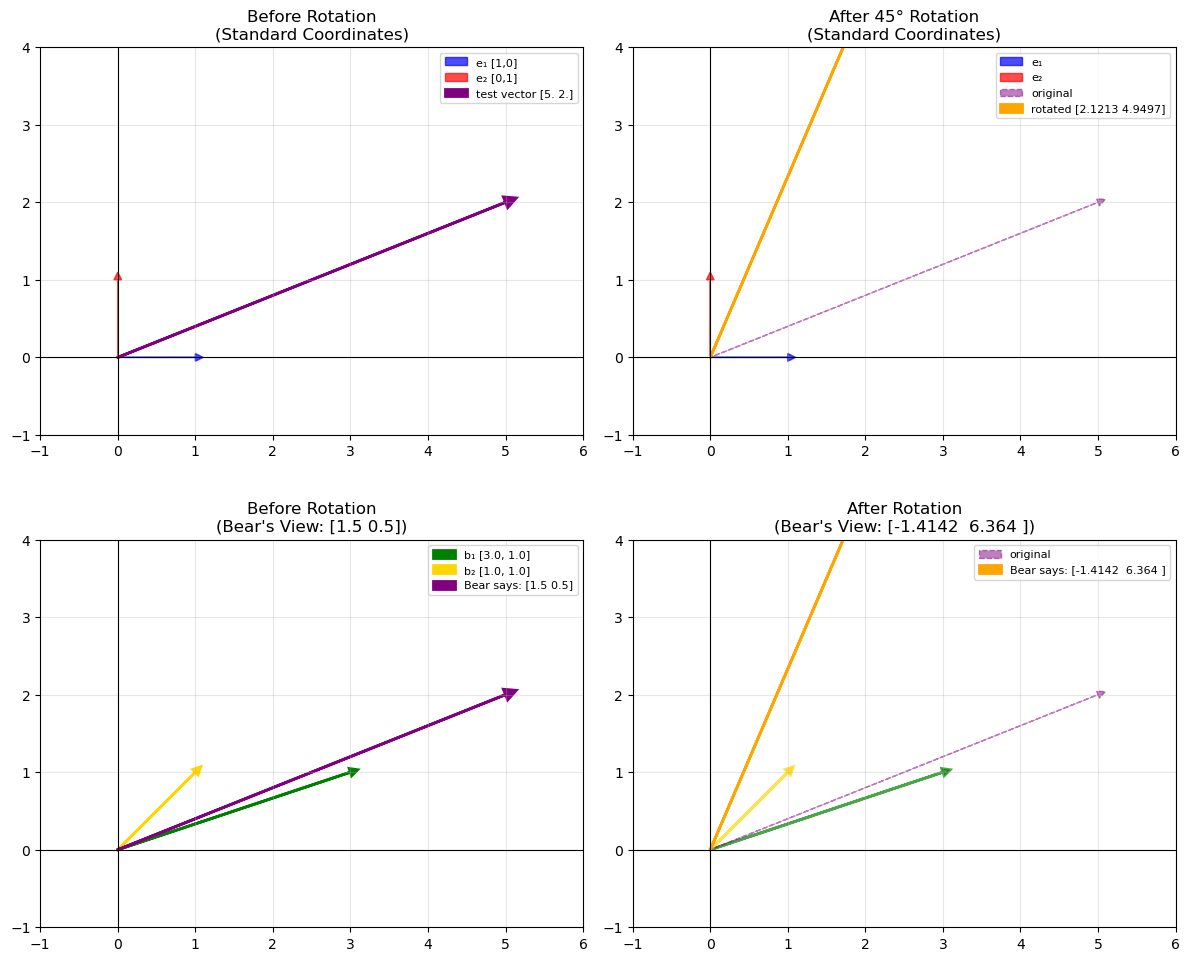

🔍 VERIFICATION:
Standard coordinates: [2.1213 4.9497]
Bear's coordinates:   [-1.4142  6.364 ]
Convert Bear→World:   [2.1213 4.9497]
Results match? True


In [16]:
# Let's visualize how the transformation works in both coordinate systems
def plot_transformation_comparison():
    """Visualize the same rotation in standard vs Bear's coordinate systems."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Test vector in Bear's coordinates
    v_bear_test = np.array([1.5, 0.5])
    v_world_test = to_world(B_bear, v_bear_test)
    
    # Apply transformations
    v_world_rot = R_standard @ v_world_test
    v_bear_rot = R_bear @ v_bear_test
    v_world_rot_check = to_world(B_bear, v_bear_rot)  # Should equal v_world_rot
    
    # === TOP ROW: Standard coordinate system ===
    
    # Plot 1: Before rotation (standard view)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.axvline(0, color='black', linewidth=0.8)
    
    # Standard basis vectors
    ax1.arrow(0, 0, 1, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue', 
              alpha=0.7, label='e₁ [1,0]')
    ax1.arrow(0, 0, 0, 1, head_width=0.1, head_length=0.1, fc='red', ec='red', 
              alpha=0.7, label='e₂ [0,1]')
    
    # Test vector
    ax1.arrow(0, 0, v_world_test[0], v_world_test[1], head_width=0.15, head_length=0.15, 
              fc='purple', ec='purple', linewidth=2, label=f'test vector {v_world_test}')
    
    ax1.set_xlim(-1, 6)
    ax1.set_ylim(-1, 4)
    ax1.set_title('Before Rotation\n(Standard Coordinates)')
    ax1.legend(fontsize=8)
    
    # Plot 2: After rotation (standard view)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.axvline(0, color='black', linewidth=0.8)
    
    # Standard basis vectors
    ax2.arrow(0, 0, 1, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue', 
              alpha=0.7, label='e₁')
    ax2.arrow(0, 0, 0, 1, head_width=0.1, head_length=0.1, fc='red', ec='red', 
              alpha=0.7, label='e₂')
    
    # Original and rotated vectors
    ax2.arrow(0, 0, v_world_test[0], v_world_test[1], head_width=0.1, head_length=0.1, 
              fc='purple', ec='purple', alpha=0.5, linestyle='--', label='original')
    ax2.arrow(0, 0, v_world_rot[0], v_world_rot[1], head_width=0.15, head_length=0.15, 
              fc='orange', ec='orange', linewidth=2, label=f'rotated {v_world_rot}')
    
    ax2.set_xlim(-1, 6)
    ax2.set_ylim(-1, 4)
    ax2.set_title('After 45° Rotation\n(Standard Coordinates)')
    ax2.legend(fontsize=8)
    
    # === BOTTOM ROW: Bear's coordinate system ===
    
    # Plot 3: Before rotation (Bear's view)
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='black', linewidth=0.8)
    ax3.axvline(0, color='black', linewidth=0.8)
    
    # Bear's basis vectors
    ax3.arrow(0, 0, bear_b1[0], bear_b1[1], head_width=0.1, head_length=0.1, 
              fc='green', ec='green', linewidth=2, label=f'b₁ {bear_b1}')
    ax3.arrow(0, 0, bear_b2[0], bear_b2[1], head_width=0.1, head_length=0.1, 
              fc='gold', ec='gold', linewidth=2, label=f'b₂ {bear_b2}')
    
    # Test vector (same geometric vector, Bear's perspective)
    ax3.arrow(0, 0, v_world_test[0], v_world_test[1], head_width=0.15, head_length=0.15, 
              fc='purple', ec='purple', linewidth=2, label=f'Bear says: {v_bear_test}')
    
    ax3.set_xlim(-1, 6)
    ax3.set_ylim(-1, 4)
    ax3.set_title(f'Before Rotation\n(Bear\'s View: {v_bear_test})')
    ax3.legend(fontsize=8)
    
    # Plot 4: After rotation (Bear's view)
    ax4.set_aspect('equal')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(0, color='black', linewidth=0.8)
    ax4.axvline(0, color='black', linewidth=0.8)
    
    # Bear's basis vectors
    ax4.arrow(0, 0, bear_b1[0], bear_b1[1], head_width=0.1, head_length=0.1, 
              fc='green', ec='green', linewidth=2, alpha=0.7)
    ax4.arrow(0, 0, bear_b2[0], bear_b2[1], head_width=0.1, head_length=0.1, 
              fc='gold', ec='gold', linewidth=2, alpha=0.7)
    
    # Original and rotated vectors
    ax4.arrow(0, 0, v_world_test[0], v_world_test[1], head_width=0.1, head_length=0.1, 
              fc='purple', ec='purple', alpha=0.5, linestyle='--', label='original')
    ax4.arrow(0, 0, v_world_rot_check[0], v_world_rot_check[1], head_width=0.15, head_length=0.15, 
              fc='orange', ec='orange', linewidth=2, label=f'Bear says: {v_bear_rot}')
    
    ax4.set_xlim(-1, 6)
    ax4.set_ylim(-1, 4)
    ax4.set_title(f'After Rotation\n(Bear\'s View: {v_bear_rot})')
    ax4.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Verification
    print("🔍 VERIFICATION:")
    print(f"Standard coordinates: {v_world_rot}")
    print(f"Bear's coordinates:   {v_bear_rot}")
    print(f"Convert Bear→World:   {v_world_rot_check}")
    print(f"Results match? {np.allclose(v_world_rot, v_world_rot_check)}")

plot_transformation_comparison()

## Intuition: Why B⁻¹RB? 🤔

**Think of it as a "translation sandwich":**

### 🥪 The Three-Layer Sandwich
1. **Bottom bread (B):** Translate FROM Bear's language TO standard language
2. **Filling (R):** Apply the transformation (this only works in standard language)  
3. **Top bread ($B^{-1}$):** Translate FROM standard language BACK TO Bear's language

### 🔄 The Process Step-by-Step
```
Bear coords → [B] → Standard coords → [R] → Rotated standard → [$B^{-1}$] → Bear coords
    v_bear           v_world              v_world_rot              v_bear_rot
```

### 🎯 Why This Works
- $B$ encodes Bear's coordinate system: Each column shows where Bear's basis vectors point in standard coordinates
- $R$ only knows standard coordinates: It's designed to work with our familiar x,y axes
- $B^{-1}$ extracts Bear coordinates: It figures out how to express any standard vector in Bear's language

### 🌟 The Beautiful Result
Instead of doing 3 separate matrix multiplications every time:
$$
v_{\text{bear,rot}} = B^{-1}\big(R (B v_{\text{bear}})\big)
$$

We can precompute one matrix and use it directly:
$$
v_{\text{bear,rot}} = (B^{-1} R B)\, v_{\text{bear}}
$$

**Same result, much more efficient!**

### 🤝 Real-World Analogy
It's like having a universal translator for mathematical operations. Once you build the translator ($B^{-1}RB$), you can apply any transformation directly in the foreign language without constantly converting back and forth!


## Generalization to any linear map

If a linear map has matrix **T** in the standard basis, then in any basis with matrix **B** (columns are the new basis vectors in standard coordinates),
$$
T_{\text{(new basis)}} = B^{-1} T B.
$$
This includes rotations, scalings, shears, reflections, projections, etc.



## Try it yourself: scaling and shear

- **Scaling** by factors $(s_x, s_y)$ in world: $S = \begin{bmatrix}s_x & 0\\ 0 & s_y\end{bmatrix}$.  
- **Shear** in x by factor $k$: $H = \begin{bmatrix}1 & k\\ 0 & 1\end{bmatrix}$.

Compute $B^{-1} S B$ or $B^{-1} H B$ and apply to Bear-vectors; compare with long-way application.


In [17]:
# Test similarity transforms with different types of transformations
print("🎨 TESTING OTHER TRANSFORMATIONS")
print("="*40)

# Define different transformations in standard coordinates
S_standard = np.diag([2.0, 0.5])     # Scale: 2x in x-direction, 0.5x in y-direction
H_standard = np.array([[1.0, 1.2],   # Shear: x → x + 1.2y, y → y (tilt rightward)  
                       [0.0, 1.0]])

print("Standard coordinate transformations:")
print(f"Scaling matrix S:\n{S_standard}")
print(f"(Stretches x by 2, shrinks y by 0.5)")
print(f"\nShear matrix H:\n{H_standard}")  
print(f"(Tilts shapes rightward)")

# Compute similarity transforms for Bear's coordinate system
S_bear = similarity_transform(B_bear, S_standard)
H_bear = similarity_transform(B_bear, H_standard)

print(f"\nSame transformations in Bear's coordinates:")
print(f"Scaling in Bear's system:\n{S_bear}")
print(f"\nShear in Bear's system:\n{H_bear}")

print(f"\n🧪 VERIFICATION: Testing on example vectors")
print("-" * 50)

# Test with a couple of vectors
test_vectors = [
    np.array([0.7, -1.3]),
    np.array([2.0, 0.5])
]

for i, v_bear in enumerate(test_vectors):
    print(f"\nTest vector {i+1}: {v_bear}")
    
    # Test scaling
    long_S = apply_transform_in_basis(B_bear, S_standard, v_bear)
    short_S = S_bear @ v_bear
    match_S = np.allclose(long_S, short_S)
    
    print(f"  Scaling - Long way:  {long_S}")
    print(f"           Short way:  {short_S}")
    print(f"           Match?      {match_S} {'✓' if match_S else '✗'}")
    
    # Test shearing  
    long_H = apply_transform_in_basis(B_bear, H_standard, v_bear)
    short_H = H_bear @ v_bear
    match_H = np.allclose(long_H, short_H)
    
    print(f"  Shear   - Long way:  {long_H}")
    print(f"           Short way:  {short_H}")
    print(f"           Match?      {match_H} {'✓' if match_H else '✗'}")

print(f"\n🎯 Key Takeaway:")
print(f"   Similarity transforms work for ANY linear transformation!")
print(f"   Rotations, scaling, shearing, reflections, projections - all follow B⁻¹TB")

🎨 TESTING OTHER TRANSFORMATIONS
Standard coordinate transformations:
Scaling matrix S:
[[2.  0. ]
 [0.  0.5]]
(Stretches x by 2, shrinks y by 0.5)

Shear matrix H:
[[1.  1.2]
 [0.  1. ]]
(Tilts shapes rightward)

Same transformations in Bear's coordinates:
Scaling in Bear's system:
[[ 2.75  0.75]
 [-2.25 -0.25]]

Shear in Bear's system:
[[ 1.6  0.6]
 [-0.6  0.4]]

🧪 VERIFICATION: Testing on example vectors
--------------------------------------------------

Test vector 1: [ 0.7 -1.3]
  Scaling - Long way:  [ 0.95 -1.25]
           Short way:  [ 0.95 -1.25]
           Match?      True ✓
  Shear   - Long way:  [ 0.34 -0.94]
           Short way:  [ 0.34 -0.94]
           Match?      True ✓

Test vector 2: [2.  0.5]
  Scaling - Long way:  [ 5.875 -4.625]
           Short way:  [ 5.875 -4.625]
           Match?      True ✓
  Shear   - Long way:  [ 3.5 -1. ]
           Short way:  [ 3.5 -1. ]
           Match?      True ✓

🎯 Key Takeaway:
   Similarity transforms work for ANY linear transfo

## 🎯 Practice Exercises

**Goal:** Master similarity transformations through hands-on practice.

### Exercise 1: Manual Calculation 🧮
**Challenge:** Compute $R_{\text{Bear}} = B^{-1} R B$ by hand for our example.

Given: $$B = \begin{bmatrix}3 & 1\\1 & 1\end{bmatrix}, \quad R = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & -1\\1 & 1\end{bmatrix}$$

**Steps:**
1. Calculate $B^{-1}$ using the $2\times 2$ inverse formula
2. Multiply $B^{-1} \cdot R$ (left multiplication)  
3. Multiply the result by $B$ (right multiplication)
4. Compare with the numerical result from our code

### Exercise 2: Vector Verification ✅
**Challenge:** Pick your own vector and verify the similarity transform works.

**Instructions:**
1. Choose any vector $v_{\text{Bear}}$ in Bear's coordinates
2. Apply the "long way": $B^{-1} R (B v_{\text{Bear}})$
3. Apply the "short way": $(B^{-1} R B) v_{\text{Bear}}$  
4. Verify they give the same result

### Exercise 3: Different Transformation 🔄
**Challenge:** Test similarity transforms with a new transformation.

Given shear matrix: $T = \begin{bmatrix}1 & 2\\0 & 1\end{bmatrix}$

**Tasks:**
1. Compute $T_{\text{Bear}} = B^{-1} T B$
2. Test on 2-3 random vectors
3. Verify consistency between long and short methods

### Exercise 4: Conceptual Understanding 🧠
**Challenge:** Explain the similarity transform in your own words.

**Questions:**
1. Why do we need $B^{-1} R B$ instead of just $R$?
2. What happens if we use $B R B^{-1}$ instead? (Try it!)
3. In one sentence, explain why similarity transforms arise when changing coordinates.

---

### 💡 Hints
- For $2\times 2$ matrices: $\begin{bmatrix}a & b\\c & d\end{bmatrix}^{-1} = \frac{1}{ad-bc}\begin{bmatrix}d & -b\\-c & a\end{bmatrix}$
- Remember: matrix multiplication is associative but not commutative
- Always verify your work with numerical checks!

In [18]:
# ========================================
# EXERCISE SOLUTIONS  
# ========================================

print("📚 EXERCISE SOLUTIONS")
print("="*50)

# Exercise 1: Manual calculation of B^(-1)RB
print("\n🧮 EXERCISE 1: Manual Calculation")
print("-" * 35)

B_manual = np.array([[3., 1.], [1., 1.]])
R_manual = (1/np.sqrt(2)) * np.array([[1., -1.], [1., 1.]])

# Step 1: Calculate B^(-1) manually using 2x2 formula
# For [[a,b],[c,d]], inverse is (1/(ad-bc)) * [[d,-b],[-c,a]]
det_B = B_manual[0,0]*B_manual[1,1] - B_manual[0,1]*B_manual[1,0]  # ad - bc
B_inv_manual = (1/det_B) * np.array([[B_manual[1,1], -B_manual[0,1]], 
                                     [-B_manual[1,0], B_manual[0,0]]])

print(f"B = \n{B_manual}")
print(f"det(B) = {B_manual[0,0]}×{B_manual[1,1]} - {B_manual[0,1]}×{B_manual[1,0]} = {det_B}")
print(f"B^(-1) = (1/{det_B}) × [[{B_manual[1,1]}, {-B_manual[0,1]}], [{-B_manual[1,0]}, {B_manual[0,0]}]]")
print(f"B^(-1) = \n{B_inv_manual}")

# Step 2: Calculate B^(-1)R  
BR_product = B_inv_manual @ R_manual
print(f"\nB^(-1)R = \n{BR_product}")

# Step 3: Calculate (B^(-1)R)B
R_bear_manual = BR_product @ B_manual
print(f"\n(B^(-1)R)B = \n{R_bear_manual}")

# Verify against numerical result
print(f"\nVerification against numpy result:")
print(f"Manual calculation:  \n{R_bear_manual}")
print(f"Numpy calculation:   \n{R_bear}")
print(f"Results match? {np.allclose(R_bear_manual, R_bear)}")

# ========================================
# Exercise 2: Vector verification
print(f"\n✅ EXERCISE 2: Vector Verification") 
print("-" * 35)

my_vector = np.array([2.5, -1.8])
print(f"Chosen vector: {my_vector}")

# Long way calculation
long_result = apply_transform_in_basis(B_bear, R_standard, my_vector)
print(f"Long way:  B^(-1)R(Bv) = {long_result}")

# Short way calculation  
short_result = R_bear @ my_vector
print(f"Short way: (B^(-1)RB)v = {short_result}")

print(f"Results match? {np.allclose(long_result, short_result)}")

# ========================================
# Exercise 3: Different transformation
print(f"\n🔄 EXERCISE 3: Testing Shear Transformation")
print("-" * 45)

T_shear = np.array([[1., 2.], [0., 1.]])
print(f"Shear matrix T = \n{T_shear}")

T_bear = similarity_transform(B_bear, T_shear)
print(f"T in Bear's coordinates = \n{T_bear}")

# Test on random vectors
test_vectors_ex3 = [np.array([1.0, 0.5]), np.array([-0.7, 2.1]), np.array([0.0, -1.5])]

for i, v in enumerate(test_vectors_ex3):
    long_way = apply_transform_in_basis(B_bear, T_shear, v)
    short_way = T_bear @ v
    match = np.allclose(long_way, short_way)
    print(f"Vector {i+1}: {v} → Long: {long_way}, Short: {short_way}, Match: {match}")

# ========================================
# Exercise 4: What happens with wrong order?
print(f"\n🧠 EXERCISE 4: What if we use BRB^(-1)?")
print("-" * 42)

# Try the wrong order: BRB^(-1) instead of B^(-1)RB
wrong_transform = B_bear @ R_standard @ np.linalg.inv(B_bear)
print(f"Wrong order BRB^(-1) = \n{wrong_transform}")
print(f"Correct B^(-1)RB =     \n{R_bear}")

# Test on a vector to see the difference
test_v = np.array([1.0, 1.0])
correct_result = R_bear @ test_v
wrong_result = wrong_transform @ test_v

print(f"\nTesting on vector {test_v}:")
print(f"Correct result:  {correct_result}")
print(f"Wrong result:    {wrong_result}")
print(f"Same result?     {np.allclose(correct_result, wrong_result)}")

print(f"\n💡 Conceptual Answer:")
print(f"We need B^(-1)RB because:")
print(f"• B converts FROM Bear's coordinates TO standard coordinates")
print(f"• R applies the transformation IN standard coordinates")  
print(f"• B^(-1) converts FROM standard coordinates BACK TO Bear's coordinates")
print(f"• The order B^(-1)RB represents this sequence: Bear→Standard→Transform→Bear")
print(f"• Using BRB^(-1) would represent: Standard→Bear→Transform→Standard (wrong!)")

print(f"\n🌟 Bottom Line:")
print(f"Similarity transforms arise because linear transformations are")
print(f"coordinate-dependent, but geometry is coordinate-independent!")

📚 EXERCISE SOLUTIONS

🧮 EXERCISE 1: Manual Calculation
-----------------------------------
B = 
[[3. 1.]
 [1. 1.]]
det(B) = 3.0×1.0 - 1.0×1.0 = 2.0
B^(-1) = (1/2.0) × [[1.0, -1.0], [-1.0, 3.0]]
B^(-1) = 
[[ 0.5 -0.5]
 [-0.5  1.5]]

B^(-1)R = 
[[ 0.     -0.7071]
 [ 0.7071  1.4142]]

(B^(-1)R)B = 
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]

Verification against numpy result:
Manual calculation:  
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]
Numpy calculation:   
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]
Results match? True

✅ EXERCISE 2: Vector Verification
-----------------------------------
Chosen vector: [ 2.5 -1.8]
Long way:  B^(-1)R(Bv) = [-0.495   5.0205]
Short way: (B^(-1)RB)v = [-0.495   5.0205]
Results match? True

🔄 EXERCISE 3: Testing Shear Transformation
---------------------------------------------
Shear matrix T = 
[[1. 2.]
 [0. 1.]]
T in Bear's coordinates = 
[[ 2.  1.]
 [-1. -0.]]
Vector 1: [1.  0.5] → Long: [ 2.5 -1. ], Short: [ 2.5 -1. ], Match: True
Vector 2: [-0.7  2.1] → Long: [0

In [19]:
# ========================================
# EXERCISE SOLUTIONS  
# ========================================

print("📚 EXERCISE SOLUTIONS")
print("="*50)

# Exercise 1: Manual calculation of B^(-1)RB
print("\n🧮 EXERCISE 1: Manual Calculation")
print("-" * 35)

B_manual = np.array([[3., 1.], [1., 1.]])
R_manual = (1/np.sqrt(2)) * np.array([[1., -1.], [1., 1.]])

# Step 1: Calculate B^(-1) manually using 2x2 formula
# For [[a,b],[c,d]], inverse is (1/(ad-bc)) * [[d,-b],[-c,a]]
det_B = B_manual[0,0]*B_manual[1,1] - B_manual[0,1]*B_manual[1,0]  # ad - bc
B_inv_manual = (1/det_B) * np.array([[B_manual[1,1], -B_manual[0,1]], 
                                     [-B_manual[1,0], B_manual[0,0]]])

print(f"B = \n{B_manual}")
print(f"det(B) = {B_manual[0,0]}×{B_manual[1,1]} - {B_manual[0,1]}×{B_manual[1,0]} = {det_B}")
print(f"B^(-1) = (1/{det_B}) × [[{B_manual[1,1]}, {-B_manual[0,1]}], [{-B_manual[1,0]}, {B_manual[0,0]}]]")
print(f"B^(-1) = \n{B_inv_manual}")

# Step 2: Calculate B^(-1)R  
BR_product = B_inv_manual @ R_manual
print(f"\nB^(-1)R = \n{BR_product}")

# Step 3: Calculate (B^(-1)R)B
R_bear_manual = BR_product @ B_manual
print(f"\n(B^(-1)R)B = \n{R_bear_manual}")

# Verify against numerical result
print(f"\nVerification against numpy result:")
print(f"Manual calculation:  \n{R_bear_manual}")
print(f"Numpy calculation:   \n{R_bear}")
print(f"Results match? {np.allclose(R_bear_manual, R_bear)}")

# ========================================
# Exercise 2: Vector verification
print(f"\n✅ EXERCISE 2: Vector Verification") 
print("-" * 35)

my_vector = np.array([2.5, -1.8])
print(f"Chosen vector: {my_vector}")

# Long way calculation
long_result = apply_transform_in_basis(B_bear, R_standard, my_vector)
print(f"Long way:  B^(-1)R(Bv) = {long_result}")

# Short way calculation  
short_result = R_bear @ my_vector
print(f"Short way: (B^(-1)RB)v = {short_result}")

print(f"Results match? {np.allclose(long_result, short_result)}")

# ========================================
# Exercise 3: Different transformation
print(f"\n🔄 EXERCISE 3: Testing Shear Transformation")
print("-" * 45)

T_shear = np.array([[1., 2.], [0., 1.]])
print(f"Shear matrix T = \n{T_shear}")

T_bear = similarity_transform(B_bear, T_shear)
print(f"T in Bear's coordinates = \n{T_bear}")

# Test on random vectors
test_vectors_ex3 = [np.array([1.0, 0.5]), np.array([-0.7, 2.1]), np.array([0.0, -1.5])]

for i, v in enumerate(test_vectors_ex3):
    long_way = apply_transform_in_basis(B_bear, T_shear, v)
    short_way = T_bear @ v
    match = np.allclose(long_way, short_way)
    print(f"Vector {i+1}: {v} → Long: {long_way}, Short: {short_way}, Match: {match}")

# ========================================
# Exercise 4: What happens with wrong order?
print(f"\n🧠 EXERCISE 4: What if we use BRB^(-1)?")
print("-" * 42)

# Try the wrong order: BRB^(-1) instead of B^(-1)RB
wrong_transform = B_bear @ R_standard @ np.linalg.inv(B_bear)
print(f"Wrong order BRB^(-1) = \n{wrong_transform}")
print(f"Correct B^(-1)RB =     \n{R_bear}")

# Test on a vector to see the difference
test_v = np.array([1.0, 1.0])
correct_result = R_bear @ test_v
wrong_result = wrong_transform @ test_v

print(f"\nTesting on vector {test_v}:")
print(f"Correct result:  {correct_result}")
print(f"Wrong result:    {wrong_result}")
print(f"Same result?     {np.allclose(correct_result, wrong_result)}")

print(f"\n💡 Conceptual Answer:")
print(f"We need B^(-1)RB because:")
print(f"• B converts FROM Bear's coordinates TO standard coordinates")
print(f"• R applies the transformation IN standard coordinates")  
print(f"• B^(-1) converts FROM standard coordinates BACK TO Bear's coordinates")
print(f"• The order B^(-1)RB represents this sequence: Bear→Standard→Transform→Bear")
print(f"• Using BRB^(-1) would represent: Standard→Bear→Transform→Standard (wrong!)")

print(f"\n🌟 Bottom Line:")
print(f"Similarity transforms arise because linear transformations are")
print(f"coordinate-dependent, but geometry is coordinate-independent!")

📚 EXERCISE SOLUTIONS

🧮 EXERCISE 1: Manual Calculation
-----------------------------------
B = 
[[3. 1.]
 [1. 1.]]
det(B) = 3.0×1.0 - 1.0×1.0 = 2.0
B^(-1) = (1/2.0) × [[1.0, -1.0], [-1.0, 3.0]]
B^(-1) = 
[[ 0.5 -0.5]
 [-0.5  1.5]]

B^(-1)R = 
[[ 0.     -0.7071]
 [ 0.7071  1.4142]]

(B^(-1)R)B = 
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]

Verification against numpy result:
Manual calculation:  
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]
Numpy calculation:   
[[-0.7071 -0.7071]
 [ 3.5355  2.1213]]
Results match? True

✅ EXERCISE 2: Vector Verification
-----------------------------------
Chosen vector: [ 2.5 -1.8]
Long way:  B^(-1)R(Bv) = [-0.495   5.0205]
Short way: (B^(-1)RB)v = [-0.495   5.0205]
Results match? True

🔄 EXERCISE 3: Testing Shear Transformation
---------------------------------------------
Shear matrix T = 
[[1. 2.]
 [0. 1.]]
T in Bear's coordinates = 
[[ 2.  1.]
 [-1. -0.]]
Vector 1: [1.  0.5] → Long: [ 2.5 -1. ], Short: [ 2.5 -1. ], Match: True
Vector 2: [-0.7  2.1] → Long: [0

## 🎓 Summary & Key Takeaways

### The Big Picture
**Similarity transformations** solve the problem of applying known transformations in different coordinate systems. It's like having a universal translator for mathematical operations.

### The Golden Formula
For any transformation $R$ in standard coordinates and any basis $B$:
$$
R_{\text{new basis}} = B^{-1} R B
$$

### The Three-Step Process
1. **Convert to standard:** Multiply by $B$
2. **Apply transformation:** Multiply by $R$  
3. **Convert back:** Multiply by $B^{-1}$
4. **Combine:** The result is $B^{-1} R B$

### Key Insights

| Concept | Explanation |
|---------|-------------|
| **Same geometry, different numbers** | The transformation does the same thing geometrically, but the matrix entries are different |
| **Universal applicability** | Works for rotations, scaling, shearing, reflections - any linear transformation |
| **Computational efficiency** | Precompute $B^{-1} R B$ once, then apply directly to vectors in the new basis |
| **Coordinate independence** | Physics/geometry shouldn't depend on your choice of coordinates |

### Real-World Applications

- **Computer Graphics:** Converting between object space, world space, and camera space
- **Robotics:** Transforming between different robot joint coordinate systems  
- **Machine Learning:** Principal Component Analysis (PCA) transforms to decorrelated coordinates
- **Physics:** Changing reference frames in mechanics and electromagnetism
- **Engineering:** Finite element analysis in different coordinate systems

### Memory Aids

**"Translation Sandwich":** $B^{-1}$ (translate back) $R$ (transform) $B$ (translate to)

**"Change of Basis Recipe":** 
1. If you know a transformation in coordinate system A
2. And want to apply it in coordinate system B  
3. Use: $(\text{A→B})^{-1} \cdot \text{Transform}_A \cdot (\text{A→B})$

### Pro Tips
- ✅ Always verify with the "long way" calculation
- ✅ Check that $B^{-1} R B$ has the same determinant as $R$ (similar matrices have same determinant)
- ✅ For orthonormal bases, $B^{-1} = B^T$ (makes calculations easier)
- ⚠️ Order matters: it's $B^{-1} R B$, not $B R B^{-1}$
- 🚫 Don't confuse similarity transforms with matrix similarity in general (this is a special case)

**The most important insight:** Similarity transformations preserve the geometric meaning of operations while adapting them to different coordinate representations. The math changes, but the geometry stays the same! 🌟